In [1]:
import json
import os
import torch
# Load the configuration from the JSON file
with open(r'C:\Users\Rishabh\Documents\3d-hcct\config.json', 'r') as f:
    config = json.load(f)

In [2]:
from model import ViTForClassfication

# Initialize the model with the loaded configuration
model = ViTForClassfication(config=config)

In [3]:
from collections import OrderedDict
checkpoint_path = r'C:\Users\Rishabh\training_output_metricsHCCT_best_model.pth.tar'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint['state_dict']

# Remove 'module.' prefix if it exists
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')  # strip the prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict, strict=True)  # strict ensures all match


<All keys matched successfully>

In [4]:
import nibabel as nib
import pandas as pd
DataFolder = r'C:\Users\Rishabh\Documents\TrimeseData'
CSVPath = r'C:\Users\Rishabh\Documents\TransBTS\IXI.xlsx'
Files = os.listdir(DataFolder)
ixi_ids = [int(f[3:6]) for f in Files]
print(ixi_ids)  # [2, 19, 20]

[2, 2, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 81, 83, 83, 84, 84, 85, 85, 86, 86, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91, 92, 92, 93, 93, 94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, 99, 100, 100, 101]


In [5]:
df = pd.read_excel(CSVPath)

In [6]:
df[df['IXI_ID']==13]['AGE'].values[0]

np.float64(46.71047227926078)

In [7]:
from collections import defaultdict
import torch.nn as nn

# global, one-time
hook_handles = []

# per-forward (per-file) scratch
_step_attn = defaultdict(dict)  # (block, head) -> probs (on device, requires_grad)
_step_grad = defaultdict(dict)  # (block, head) -> grad  (on device)

def _save_probs_with_grad(key, probs):
    _step_attn[key] = probs              # keep forward tensor for this step only
    probs.retain_grad()
    probs.register_hook(lambda g, k=key: _step_grad.__setitem__(k, g))

def make_head_hook(bi, hi):
    def head_hook(module, inp, out):
        probs = out[1] if isinstance(out, (tuple, list)) and len(out) >= 2 else None
        if probs is not None:
            _save_probs_with_grad((bi, hi), probs)
    return head_hook

# Register ONCE
if not hook_handles:  # prevents duplicates if you rerun the cell
    for bi, blk in enumerate(model.encoder.blocks):
        if hasattr(blk.attention, "heads") and isinstance(blk.attention.heads, nn.ModuleList):
            for hi, head in enumerate(blk.attention.heads):
                h = head.register_forward_hook(make_head_hook(bi, hi))
                hook_handles.append(h)
        elif hasattr(blk.attention, "qkv_projection"):  # Faster path
            def make_fast_hook(bi):
                def fast_hook(module, inp, out):
                    probs = out[1] if isinstance(out, (tuple, list)) and len(out) >= 2 else None
                    if probs is not None:
                        _save_probs_with_grad((bi, -1), probs)  # -1 denotes "stacked heads" tensor [B,H,T,T]
                return fast_hook
            h = blk.attention.register_forward_hook(make_fast_hook(bi))
            hook_handles.append(h)


In [8]:

def white0(image, threshold=0):
    """
    Standardize voxels with value > threshold

    Args:
        image: Input image
        threshold: Threshold value

    Returns:
        Standardized image
    """
    image = image.astype(np.float32)
    mask = (image > threshold).astype(int)

    # Vectorized implementation to avoid unnecessary memory allocation
    image_h = image * mask

    # Calculate mean and std only for relevant voxels
    non_zero_voxels = np.sum(mask)
    if non_zero_voxels > 0:
        mean = np.sum(image_h) / non_zero_voxels

        # More memory efficient way to calculate std
        std_sum = np.sum((image_h - mean * mask) ** 2)
        std = np.sqrt(std_sum / non_zero_voxels)

        if std > 0:
            normalized = mask * (image - mean) / std
            # Use in-place operations to reduce memory usage
            image = normalized + image * (1 - mask)
            return image

    # Default case
    return np.zeros_like(image, dtype=np.float32)

In [9]:
import os, gc
import numpy as np
import nibabel as nib
import torch

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)
model.eval()  # deterministic dropout/BN

attn_by_file = {}   # {file_id: {(b,h): [T,T] numpy}}
grad_by_file = {}   # same

indx = 40
filename = Files[indx]
_step_attn.clear()
_step_grad.clear()

file_path = os.path.join(DataFolder, filename)
img = nib.load(file_path)
x_np = img.get_fdata(caching='unchanged').astype(np.float32)       # avoid float64 bloat

inputvolume = white0(x_np)
inputvolume = torch.from_numpy(inputvolume).unsqueeze(0).unsqueeze(0).to(device).float()
inputvolume = inputvolume.to(device).type(torch.FloatTensor)




# x1 = torch.from_numpy(x_np).unsqueeze(0).unsqueeze(0).to(device)







model.zero_grad(set_to_none=True)

# forward WITH attentions
out = model(inputvolume, output_attentions=True)
logits = out[0] if isinstance(out, (tuple, list)) else out
_id = int(filename[3:6])
AGE = df[df['IXI_ID']==_id]['AGE'].values[0]
Predicted_Age = logits.item()

# scalar loss for backward (replace with real loss if labels)
loss = logits.sum()
loss.backward()

file_id = os.path.basename(filename)

attn_by_file[file_id] = {
    k: v.detach().float().cpu().squeeze(0).numpy()   # [T,T]
    for k, v in _step_attn.items()
}
grad_by_file[file_id] = {
    k: g.detach().float().cpu().squeeze(0).numpy()   # [T,T]
    for k, g in _step_grad.items()
}

original x shape:-  torch.Size([1, 1, 91, 109, 91])
x1 shape:-  torch.Size([1, 32, 45, 54, 45])
x2 shape:-  torch.Size([1, 64, 22, 27, 22])
x3 shape:-  torch.Size([1, 128, 11, 13, 11])
x4 shape:-  torch.Size([1, 256, 5, 6, 5])
x before rearrange:-  torch.Size([1, 512, 2, 3, 2])
Final x shape(patch embedding):-  torch.Size([1, 512, 12])
cls_tokens:-  torch.Size([1, 1, 12])
Embedding shape:-   torch.Size([1, 513, 12])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1, 513, 1])
key:-  torch.Size([1, 513, 1])
value:-  torch.Size([1, 513, 1])
attention_output:-  torch.Size([1, 513, 1])
attention_probs:-  torch.Size([1, 513, 513])
query:-  torch.Size([1

C:\Users\Rishabh\anaconda3\envs\3d-hcct\Lib\site-packages\torch\autograd\graph.py:829: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [10]:
print("Actual age:- ",AGE)
print("Predicted age:- ",Predicted_Age)

Actual age:-  24.763860369609855
Predicted age:-  18.386322021484375


In [11]:
Attn = []
AttnGr = []
for key in attn_by_file.keys():
    FileAttn = attn_by_file[key]
    FileAttnGrad = grad_by_file[key]
    BlockAttn = []
    BlockAttnGrad = []
    for i in range(3):
        HeadAttn = []
        HeadAttnGrad = []
        for j in range(8):
            HeadAttn.append(FileAttn[i,j])
            HeadAttnGrad.append(FileAttnGrad[i,j])
        
        HeadAttn = np.stack(HeadAttn)
        HeadAttnGrad = np.stack(HeadAttnGrad)
        BlockAttn.append(HeadAttn)
        BlockAttnGrad.append(HeadAttnGrad)
    BlockAttn = np.stack(BlockAttn)
    BlockAttnGrad = np.stack(BlockAttnGrad)
    Attn.append(BlockAttn)
    AttnGr.append(BlockAttnGrad)
    
Attn = np.stack(Attn)        
AttnGr = np.stack(AttnGr)

In [12]:
Attn.shape, AttnGr.shape

((1, 3, 8, 513, 513), (1, 3, 8, 513, 513))

In [13]:
Attn = np.mean(Attn, axis=0)
Attn = np.mean(Attn, axis=0)


AttnGr = np.mean(AttnGr, axis=0)
AttnGr = np.mean(AttnGr, axis=0)

In [14]:
import numpy as np
import torch
def grad_rollout(attentions, gradients, discard_ratio):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = attention*weights
            print(attention_heads_fused.shape)
            attention_heads_fused = attention_heads_fused.mean(axis=1)
            attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    return result

In [15]:
result = grad_rollout(torch.from_numpy(Attn), torch.from_numpy(AttnGr), 0.9)

torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])
torch.Size([513, 513])


In [16]:
result.shape

torch.Size([513, 513])

In [17]:
mask = result[0,1:]
print(len(mask))
mask = mask.reshape(8,8,8).numpy()

512


In [18]:
import numpy as np
from scipy.ndimage import zoom

# Suppose mask.shape = (depth, height, width)
zoom_factors = (91 / mask.shape[0],
                109 / mask.shape[1],
                91 / mask.shape[2])

mask = zoom(mask, zoom_factors, order=1)  # order=1 → bilinear

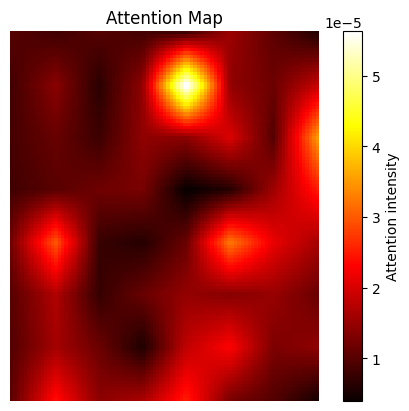

In [19]:
import matplotlib.pyplot as plt

plt.imshow(mask[34], cmap='hot')  # mask is your 2D NumPy array
plt.colorbar(label='Attention intensity')
plt.title('Attention Map')
plt.axis('off')
plt.show()

In [20]:
import nibabel as nib
import numpy as np

affine = np.eye(4)

# Create the NIfTI image
nifti_img = nib.Nifti1Image(x_np, affine)
nifti_msk = nib.Nifti1Image(mask, affine)

# Save to disk
nib.save(nifti_img, "nifti_img.nii.gz")
nib.save(nifti_msk, "nifti_msk.nii.gz")

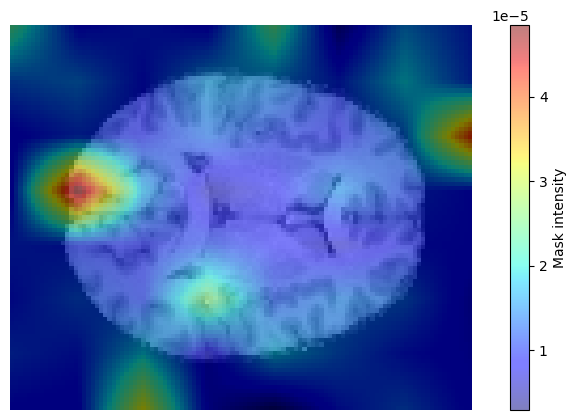

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[2] // 2  

img_slice = x_np[:, :, slice_idx]
mask_slice = mask[:, :, slice_idx]

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()


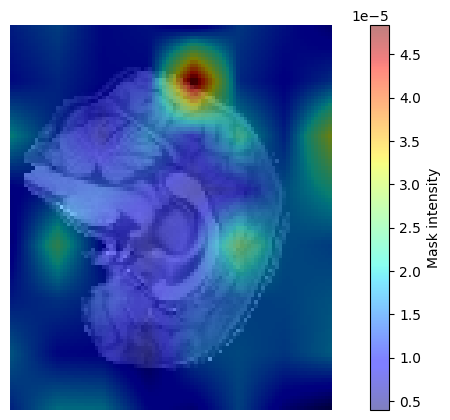

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[0] // 2  

img_slice = x_np[slice_idx, :, :]
mask_slice = mask[slice_idx, :, :]

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()

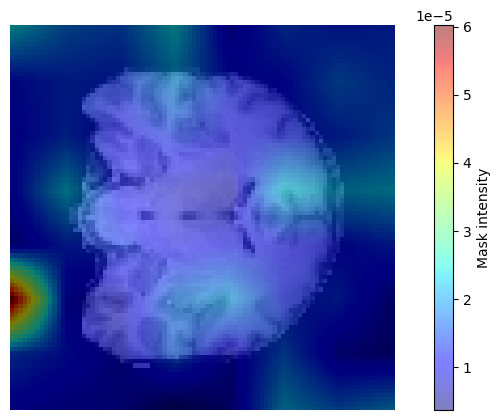

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[1] // 2  

img_slice = x_np[:, slice_idx, :]
mask_slice = mask[:,slice_idx, :]

plt.figure(figsize=(10,5))

# Show base image
plt.imshow(img_slice, cmap='gray')

# Overlay mask with transparency
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # alpha controls overlay strength
plt.colorbar(label="Mask intensity")
plt.axis("off")
plt.show()

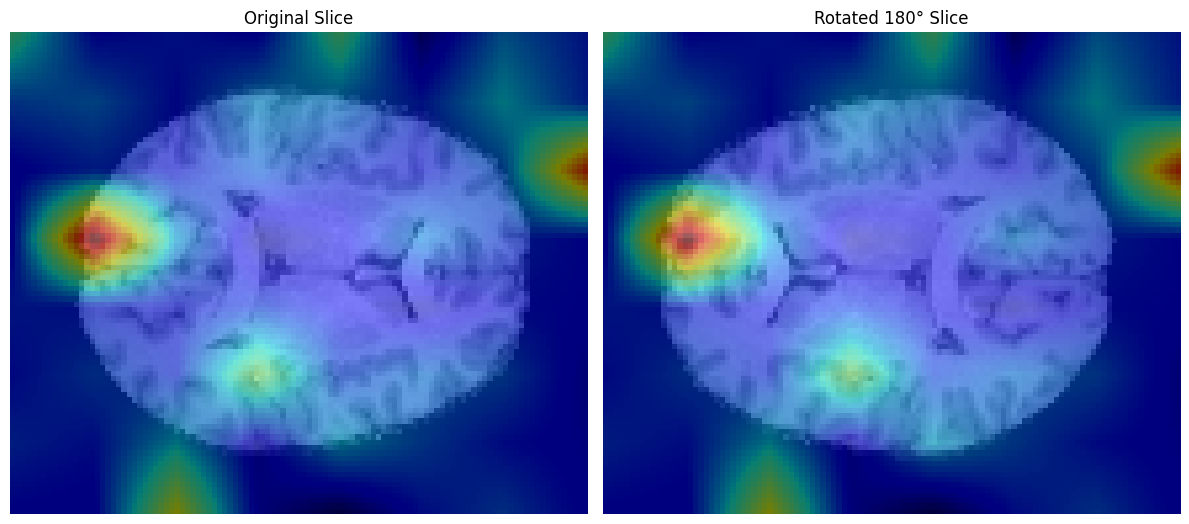

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[2] // 2  

img_slice = x_np[:, :, slice_idx]
mask_slice = mask[:, :, slice_idx]

# Rotate 180 degrees (2 times 90° rotation)
img_rot = np.rot90(img_slice, 2)
# mask_rot = np.rot90(mask_slice, 2)

plt.figure(figsize=(12,6))

# --- Original ---
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Original Slice")
plt.axis("off")

# --- Rotated ---
plt.subplot(1, 2, 2)
plt.imshow(img_rot, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Rotated 180° Slice")
plt.axis("off")

plt.tight_layout()
plt.show()


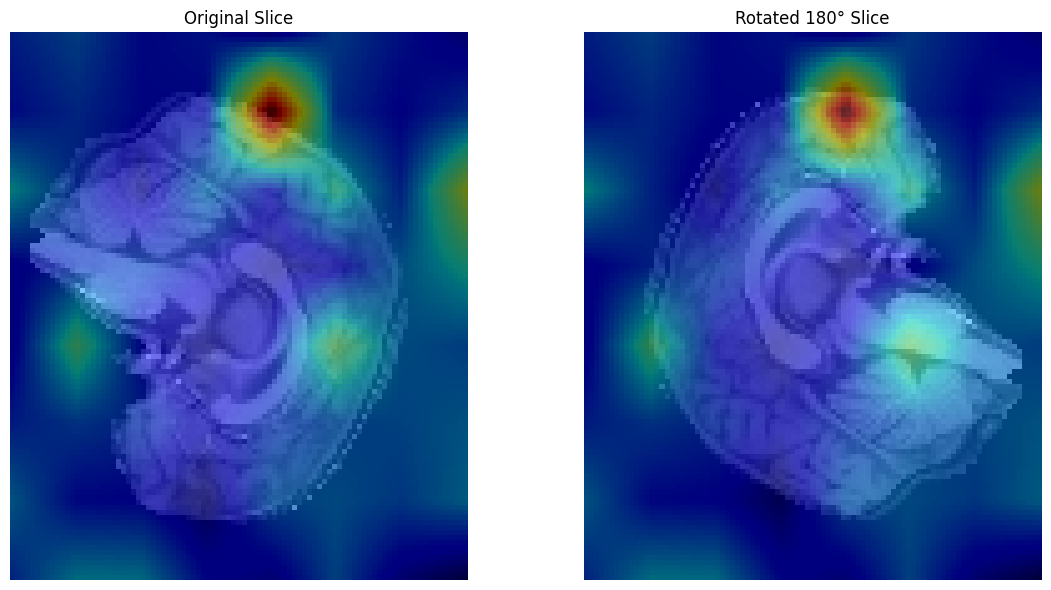

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[0] // 2  

img_slice = x_np[slice_idx, :, :]
mask_slice = mask[slice_idx, :, :]

# Rotate 180 degrees (2 times 90° rotation)
img_rot = np.rot90(img_slice, 2)
# mask_rot = np.rot90(mask_slice, 2)

plt.figure(figsize=(12,6))

# --- Original ---
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Original Slice")
plt.axis("off")

# --- Rotated ---
plt.subplot(1, 2, 2)
plt.imshow(img_rot, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Rotated 180° Slice")
plt.axis("off")

plt.tight_layout()
plt.show()


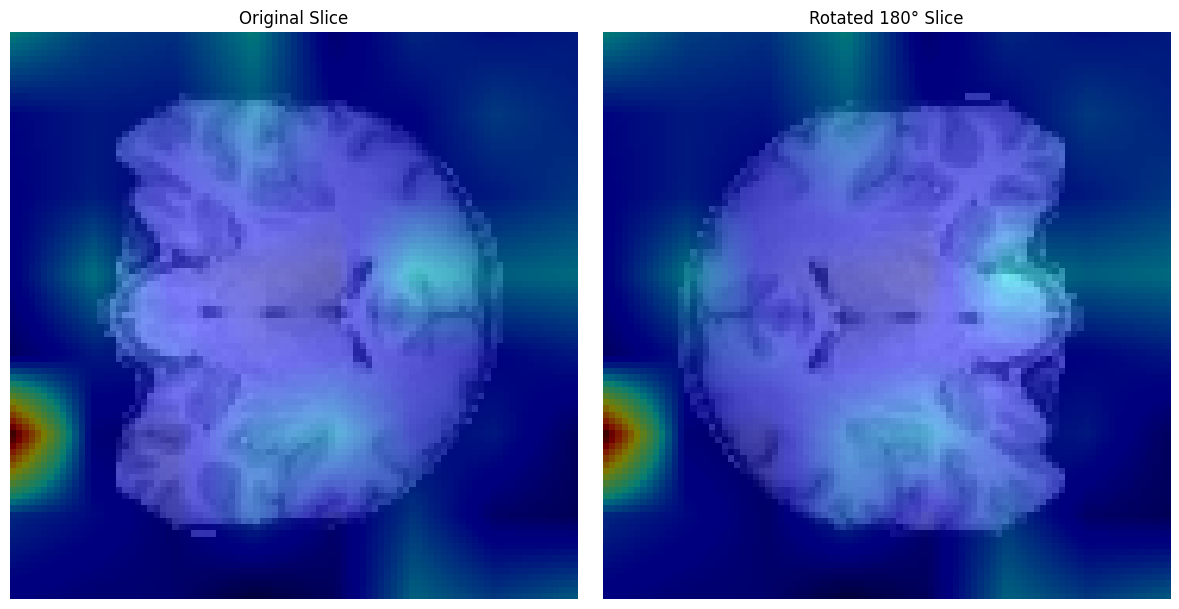

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Example: pick a middle slice along z-axis
slice_idx = x_np.shape[1] // 2  

img_slice = x_np[:, slice_idx, :]
mask_slice = mask[:,slice_idx, :]

# Rotate 180 degrees (2 times 90° rotation)
img_rot = np.rot90(img_slice, 2)
# mask_rot = np.rot90(mask_slice, 2)

plt.figure(figsize=(12,6))

# --- Original ---
plt.subplot(1, 2, 1)
plt.imshow(img_slice, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Original Slice")
plt.axis("off")

# --- Rotated ---
plt.subplot(1, 2, 2)
plt.imshow(img_rot, cmap='gray')
plt.imshow(mask_slice, cmap='jet', alpha=0.5)
plt.title("Rotated 180° Slice")
plt.axis("off")

plt.tight_layout()
plt.show()